# Introducción

___



En la primer clase se repasamos algunos conceptos clásicos sobre el aprendizaje automático. Se repasaron ahí las aproximaciones de aprendizaje supervisado, no supervisado y por refuerzo.  

Los objetivos de este _notebook_ son:
1. Cimentar algunos conceptos básicos que seguiremos viendo a lo largo del curso cuando pasemos a modelos de aprendizaje profundo (_e.g._ procesamiento de datos, funciones de pérdida, _overfitting_).
2. Ver estos conceptos en acción en un caso de aprendizaje supervisado y uno no supervisado.
3. Familiarizarnos con rudimentos de PyTorch, una librería que utilizaremos de ahora en más.

Para ello vamos a analizar un _dataset_ muy popular, llamado comunmente "_penguins dataset_". Utilizaremos estos datos para predecir el valor de una variable en función de otra (i.e., una regresión lineal) y realizar una clasificación de cada individuo en base a sus características (_i.e._, _clustering_ de los datos).


> **Nota**: Este _notebook_ está inspirado en trabajo realizado por el Dr. Ignacio Ramírez para el curso "_Aprendizaje automático básico para científicos (AABC)_", el cual compartió amablemente materiales. Dicho curso también se encuentra organizado por CICADA. 

# _"Penguins dataset"_, nuestro objeto de estudio

*Tiempo estimado: ~x horas* -> **llenar esto**

___


<div>
<center>
<img src="https://imgur.com/orZWHly.png" width="60%"/>
</center>
</div>

El [Penguins Dataset](https://github.com/allisonhorst/palmerpenguins) se trata de un _dataset_ donde se listan 5 caracteristicas para tres especies distintas de pingüinos. Los datos son: el sexo del pingüino, largo y ancho del pico ("_bill_" en ingles), el largo de la aleta ("_flipper_") y el peso en gramos de cada individuo.

<div style="text-align: center;">
  <img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/culmen_depth.png" width="500" />
</div>

En el mismo hay tres especies distribuidas en distintas islas del Archipielago de Palmer.

Como primera tarea vamos a observar nuestros datos, en lo que típicamente se llama un "análisis exploratorio".

## Análisis exploratorio del _dataset_

El primer paso es, naturalmente, importar los datos. Afortunadamente, la librería _seaborn_ posee al _dataset_ entre los datos disponibles

In [1]:
# cargamos las librerias
import seaborn as sns,  pandas as pd

# importamos el dataset
penguins = sns.load_dataset('penguins')

# llevamos al dataset a un dataframe de pandas
data = pd.DataFrame(penguins)

In [2]:
# pispeamos los datos
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


Vemos que cada fila corresponde a un individuo. En las columnas se encuentran las variables que ya habíamos mencionado

In [3]:
# con el metodo .info() podemos ver un poco más, incluyendo datos faltantes por variable
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [4]:
# con shape podemos ver las dimensiones del dataset 
print(data.shape) # cuantos individuos hay?

(344, 7)


In [5]:
# con el metodo .describe() podemos obtener algunos datos mas cuantitativos de cada variable
data.describe(include='all')

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
count,344,344,342.000000,342.000000,342.000000,342.000000,333
unique,3,3,NaN,NaN,NaN,NaN,2
top,Adelie,Biscoe,NaN,NaN,NaN,NaN,Male
freq,152,168,NaN,NaN,NaN,NaN,168
mean,NaN,NaN,43.921930,17.151170,200.915205,4201.754386,NaN
std,NaN,NaN,5.459584,1.974793,14.061714,801.954536,NaN
min,NaN,NaN,32.100000,13.100000,172.000000,2700.000000,NaN
25%,NaN,NaN,39.225000,15.600000,190.000000,3550.000000,NaN
50%,NaN,NaN,44.450000,17.300000,197.000000,4050.000000,NaN
75%,NaN,NaN,48.500000,18.700000,213.000000,4750.000000,NaN


Podemos también ver cómo pares de variables describen a nuestro dataset

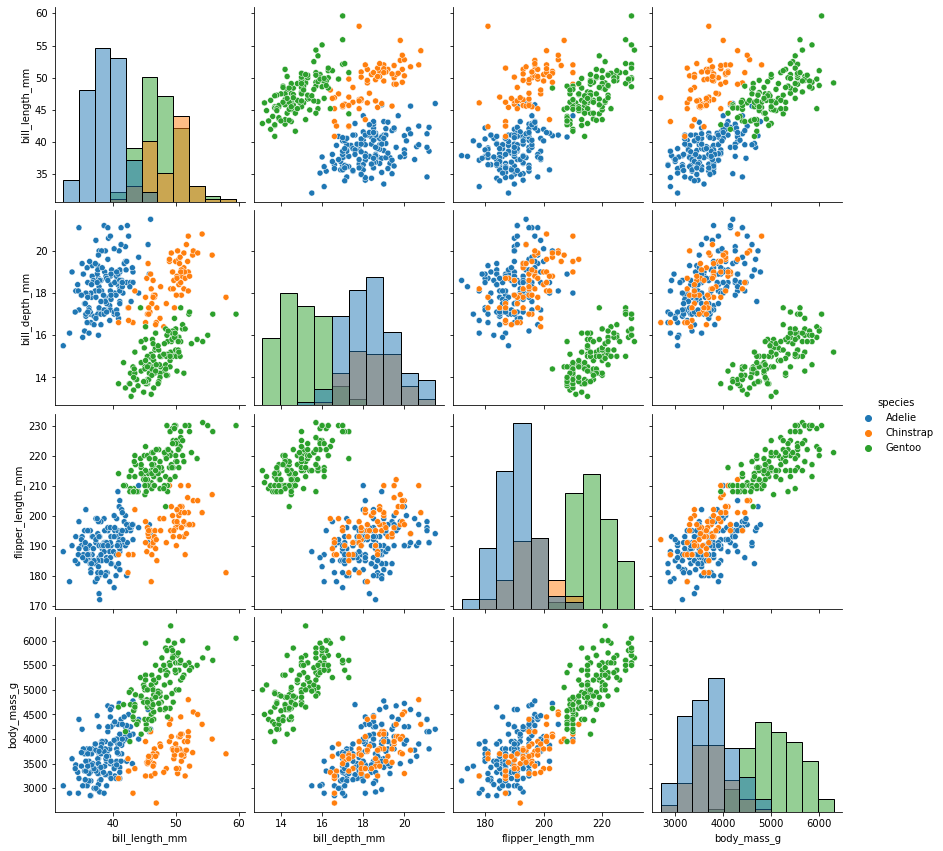

In [6]:
sns.pairplot(data, hue="species", height=3,diag_kind="hist")

Vemos, por ejemplo, que las diferentes especies de pingüino tienen diferente relación para las variables `bill_depth_depth` y `bill_length_mm`

<AxesSubplot:xlabel='bill_length_mm', ylabel='bill_depth_mm'>

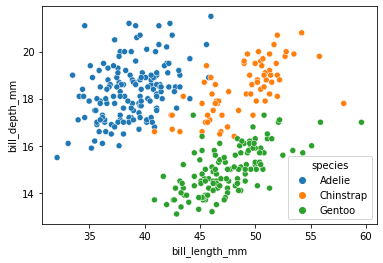

In [7]:
sns.scatterplot(data = data, hue = 'species', x = 'bill_length_mm', y = 'bill_depth_mm')

Teniendo en cuenta esto, una pregunta natural sería: ¿podríamos predecir la especie de pingüino en base a estas dos medidas del pico de una forma eficiente?

# Aprendizaje no supervisado

Para abordar este problema vamos primero a tomar un enfoque de **aprendizaje no supervisado**. Bajo este enfoque no vamos a codificar explícitamente en nuestro algoritmo de aprendizaje a qué especie pertenece cada pingüino. El princpio que opera es el siguiente: si la relación entre las variables que usamos para entrenar correlaciona bien con la especie del individuo, un algoritmo de aprendizaje eficaz debería ser capaz de detectar grupos de individuos con características similares; estos grupos deberían correlacionar con las especies de los individuos.

Para ilustrar este concepto, vemos a continuación cómo funciona el algoritmo que vamos a emplear: ***kNN*** (del inglés, _k-nearest neighbours_). 

![](https://www.tidymodels.org/learn/statistics/k-means/kmeans.gif)

In [146]:
import matplotlib.pyplot as plt

In [147]:
data.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,41.1,17.0,190.0,3800.0,Male
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


<Axes: xlabel='bill_length_mm', ylabel='bill_depth_mm'>

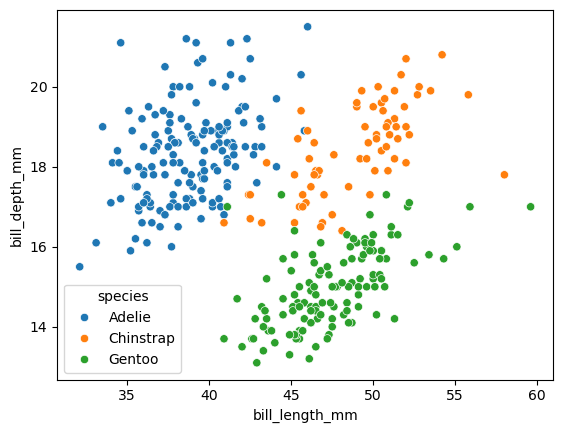

In [156]:
from sklearn.neighbors import KNeighborsClassifier # traemos el clasificador de KNN del paquete

In [157]:
# Separamos el dataset en un conjunto de entrenamiento y otro de testeo
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [160]:
# Ajustamos un modelo KNN a los datos de las columnas seleccionadas
knn = KNeighborsClassifier(n_neighbors=1) # creamos el clasificador
knn.fit(Xtrain, ytrain) # lo ajustamos a los datos

# Evaluamos el rendimiento del modelo en el set de testeo
yPredichos = knn.predict(Xtest) # obtenemos las predicciones del modelo
es_correcto = (yPredichos == ytest) # comparamos con las etiquetas reales, para ver si son correctas
score = 100*np.mean(es_correcto) # porcentaje: 100 x fracción de inferencias correctas
score = np.round(score) # redondeamos

# Imprimimos el resultado
print(f'\n Utilizando las columnas bill_length_mm y bill_depth_mm, hay un {score}% de respuestas correctas.\n')


 Utilizando las columnas bill_length_mm y bill_depth_mm, hay un 93.0% de respuestas correctas.



Pasamos a visualizar cómo clasificó el kNN...

elbow method, etc

In [161]:
yPredichos

array([1, 1, 2, 1, 2, 2, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0,
       2, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 2, 2, 2, 0,
       2, 0, 2, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1,
       1, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 1])

[1,
 1,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 1]

<Axes: xlabel='x', ylabel='y'>

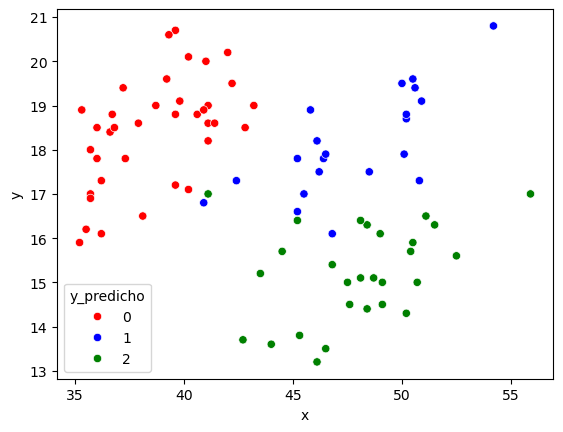

In [171]:
palette = {
    0: 'red',
    1: 'blue',
    2: 'green'
}

sns.scatterplot(data = pd.concat([pd.DataFrame.from_dict({'x': [x[0]], 'y': [x[1]], 'y_predicho': [y]}) for x,y in zip(Xtest, [z for z in yPredichos])]), x = 'x', y = 'y',
               hue = 'y_predicho', palette = palette)

## Aprendizaje supervisado: prediciendo valores contínuos




**TODO**: avanzar con esto

Correlacion:


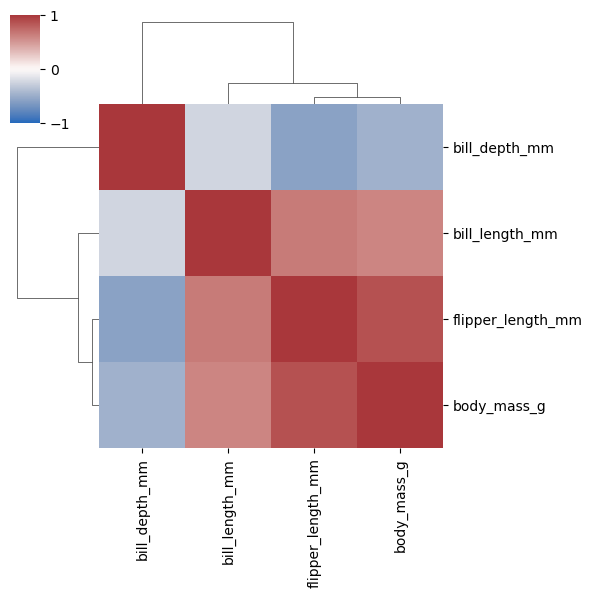

In [14]:
# calculamos la correlacion y agrupamos jerarquicamente usando el metodo .clustermap()
print('Correlacion:')
sns.clustermap(data.drop(['species', 'island','sex'], axis = 1).corr(),  
               figsize = (6,6), 
               cmap = 'vlag',
               vmax = 1, vmin = -1)

Podemos concluir entonces... **TODO**: completar...

___

**Pasemos ahora a intentar predecir, por ejemplo, el peso de un individuo a partir del largo de su aleta**, dado que estas dos variables parecen fuertemente correlacionadas. Para llevar a cabo esta tarea vamos a hacer una regresión lineal. 


Nos enfrentamos a un típico caso de ***aprendizaje supervisado***. Haremos una primer aproximación donde para una fracción de datos intentaremos hacer una predicción. Estimaremos el error en nuestro conjunto y en un conjunto de ***testeo***, que todavía no hayamos visto. Intentaremos luego modificar los pesos en nuestro modelo en una dirección donde el cambio sea favorable a realizar mejores predicciones; iteraremos el proceso durante varias ***épocas***.

**TO-DO**: incluir el concepto de validation set.


Antes que nada, veamos la relación entre las dos variables seleccionadas

<Axes: xlabel='flipper_length_mm', ylabel='body_mass_g'>

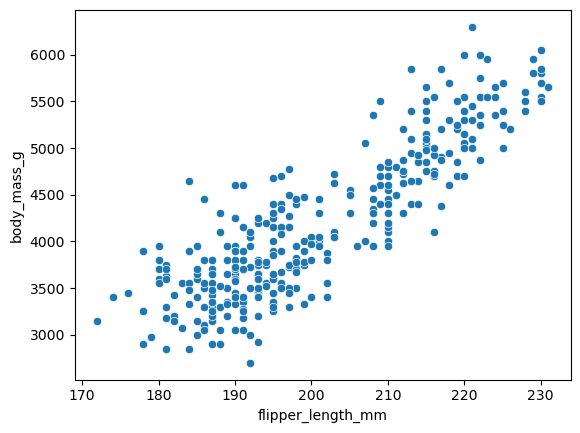

In [34]:
sns.scatterplot(data = data, x = 'flipper_length_mm', y = 'body_mass_g')

<Axes: xlabel='flipper_length_mm', ylabel='body_mass_g'>

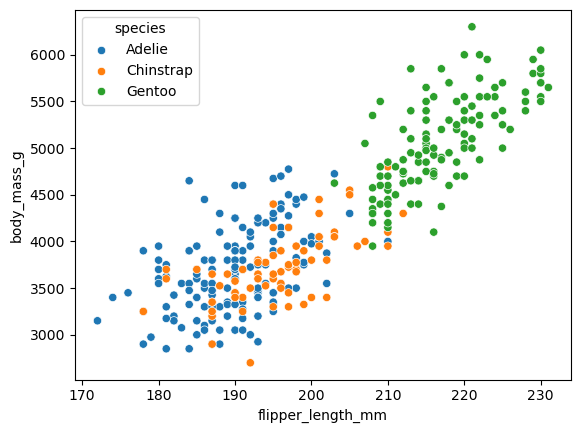

In [33]:
# vemos lo mismo segun especie?
sns.scatterplot(data = data, x = 'flipper_length_mm', y = 'body_mass_g', hue = 'species')

La relación entre ambas variables se ve bastante lineal. Podemos explorar aparte si otras variables... [**TODO**: completar]

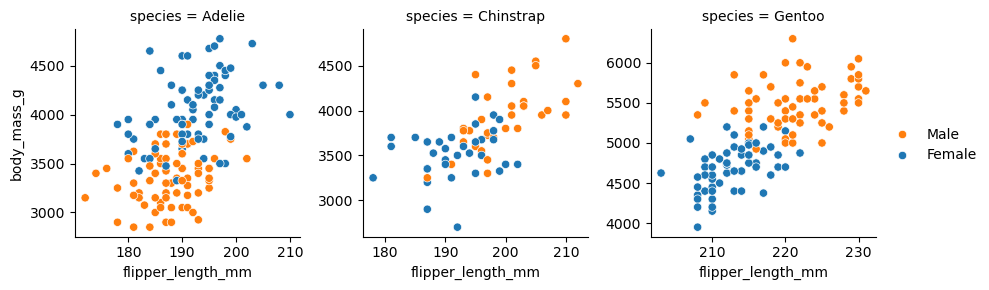

In [31]:
# y por sexo?
g = sns.FacetGrid(data, col="species", sharey = False, sharex = False)
g.map_dataframe(sns.scatterplot, x="flipper_length_mm", y="body_mass_g", hue="sex")
g.add_legend()

Ya nos divertimos un poco con los datos. Respecto a nuestra preocupación inicial (si la relación entre ambas variables podría ser estimada mediante una regresión lineal) parecería que podemos quedarnos tranquilos.

Ahora, cómo podríamos hacer esto en Python? Existen muchas formas. Como ya dijimos, el objetivo de este práctico es familiarizarnos con herramientas básicas de PyTorch, una librería para armar y entrenar modelos de aprendizaje profundo con la que vamos a trabajar el resto del curso. Teniendo en cuenta esto, naturalmente lo que nos interesa es aproximarnos a la regresión lineal desde la perspectiva de una red neuronal.

Recordemos que en una regresión lineal con una sola variable tenemos

$$y = ax + b$$

Tengamos en cuenta que entonces que, si tenemos $n$ pares de observaciones $(x_i,y_i)$, podemos expresar esto con notación matricial como

$$\begin{bmatrix} y_1 \\ y_2 \\ \vdots \\ y_n \end{bmatrix} = a \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} + b$$

o, lo que es más sencillo

$$ \mathbf{\hat{y}} = a\mathbf{x} + b$$

donde simplemente hicimos un cambio de notación. Pero si lo pensamos un poco esto no es más que una red neuronal que toma $n$ valores de entrada y devuelve un valor de salida.

Qué podemos usar en este caso como función de pérdida? En principio podríamos hacer lo que querramos. Una aproximación natural sería utilizar mínimos cuadrados

<div>
<center>
<img src="https://www.d2l.ai/_images/fit-linreg.svg" width="20%"/>
</center>
</div>


La cuestión ahora, naturalmente es: cómo podríamos implementar nuestro modelo? Ahí es donde ingresa PyTorch en nuestra vida.

In [37]:
import numpy as np

In [44]:
from sklearn.model_selection import train_test_split # separación de datos en entrenamiento y validación

In [45]:
# filtramos para asegurarnos de tener valores en ambas variables
data_r = data.query("not flipper_length_mm.isnull() and not body_mass_g.isnull()")

In [46]:
# llevamos a array de numpy
X = data_r[['flipper_length_mm']].to_numpy()
y = data_r[['body_mass_g']].to_numpy()

In [47]:
# Separamos el dataset en un conjunto de entrenamiento y otro de testeo
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [48]:
ytrain

array([[4300.],
       [4750.],
       [3300.],
       [4100.],
       [4750.],
       [4800.],
       [5550.],
       [3500.],
       [3700.],
       [3950.],
       [4000.],
       [3050.],
       [3525.],
       [4400.],
       [3350.],
       [3950.],
       [5650.],
       [4800.],
       [3450.],
       [3400.],
       [4150.],
       [6300.],
       [4100.],
       [3700.],
       [5150.],
       [4600.],
       [2900.],
       [5850.],
       [3900.],
       [4850.],
       [3450.],
       [5800.],
       [3600.],
       [3650.],
       [3650.],
       [4350.],
       [5350.],
       [3725.],
       [3325.],
       [4650.],
       [5650.],
       [3450.],
       [3600.],
       [5200.],
       [3525.],
       [5400.],
       [5350.],
       [3350.],
       [3250.],
       [3900.],
       [3850.],
       [3875.],
       [3750.],
       [4600.],
       [4750.],
       [4850.],
       [2925.],
       [3900.],
       [3600.],
       [4050.],
       [3300.],
       [5700.],
       [

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

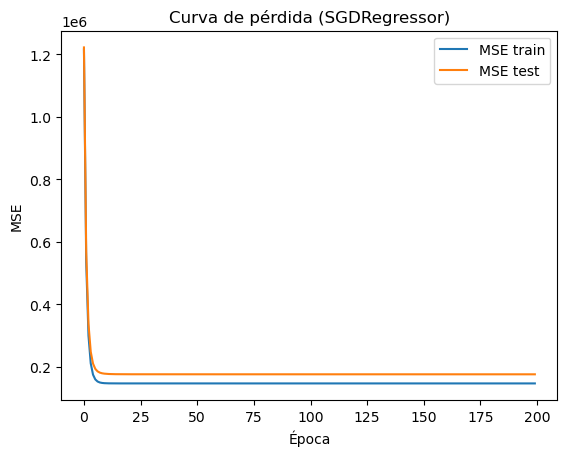

R2 final — train: 0.773 | test: 0.710


In [49]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 1) Escalamos features (SGD es muy sensible a escala)
scaler = StandardScaler()
Xtr = scaler.fit_transform(Xtrain)
Xte = scaler.transform(Xtest)

# 2) Modelo lineal entrenado por SGD (mínimos cuadrados)
sgd = SGDRegressor(loss='squared_error', penalty=None, alpha=0.0,
                   learning_rate='invscaling', eta0=0.01, random_state=0)

n_epochs = 200
mse_tr, mse_te, r2_tr, r2_te = [], [], [], []

# Inicializo y luego itero manualmente con partial_fit
sgd.partial_fit(Xtr, ytrain)
for _ in range(n_epochs):
    sgd.partial_fit(Xtr, ytrain)  # una "época" sobre todo el training
    ytr = sgd.predict(Xtr)
    yte = sgd.predict(Xte)
    mse_tr.append(mean_squared_error(ytrain, ytr))
    mse_te.append(mean_squared_error(ytest, yte))
    r2_tr.append(r2_score(ytrain, ytr))
    r2_te.append(r2_score(ytest, yte))

# 3) Plot de la pérdida (MSE) por época
plt.figure()
plt.plot(mse_tr, label='MSE train')
plt.plot(mse_te, label='MSE test')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.title('Curva de pérdida (SGDRegressor)')
plt.show()

print(f"R2 final — train: {r2_tr[-1]:.3f} | test: {r2_te[-1]:.3f}")

Perfecto, hicimos una regresión lineal usando las funciones de sk-learn. **Pero no sabemos mucho qué pasó en el medio**

- **TODO**: escribir todo esto mejor, dar el pie a lo que viene

### Un desvío valioso: conceptos básicos de PyTorch

*Tiempo estimado: ~2 horas*
___

Lo que sigue va a parecer un desvío. Vamos

> **Nota**: Esta sección está adaptada de un curso de NeuroMatch (https://deeplearning.neuromatch.io/tutorials), un recurso sumamente valioso que también te invitamos a estudiar.


PyTorch es un paquete de computación científica basado en Python dirigido a dos tipos de
público:

-  Un sustituto de NumPy optimizado para la potencia de las GPU
-  Una plataforma de aprendizaje profundo que proporciona una flexibilidad
   y una velocidad significativas

En esencia, PyTorch ofrece algunas características clave:

- Un objeto [Tensor](https://pytorch.org/docs/stable/tensors.html) multidimensional, similar a [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) pero con aceleración de GPU.
- Un motor **autograd** optimizado para calcular derivadas automáticamente.
- Una API limpia y modular para crear e implementar **modelos de aprendizaje profundo**.

Podemos encontrar más información sobre PyTorch en su página web y material asociado (https://pytorch.org/).

#### Section 2.1: Creating Tensors


There are various ways of creating tensors, and when doing any real deep learning project, we will usually have to do so.

**Construct tensors directly:**

---



In [105]:
# importando librerias
import torch, random

In [99]:
# We can construct a tensor directly from some common python iterables,
# such as list and tuple nested iterables can also be handled as long as the
# dimensions are compatible

# tensor from a list
a = torch.tensor([0, 1, 2])

#tensor from a tuple of tuples
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)

# tensor from a numpy array
c = np.ones([2, 3])
c = torch.tensor(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")

Tensor a: tensor([0, 1, 2])
Tensor b: tensor([[1.0000, 1.1000],
        [1.2000, 1.3000]])
Tensor c: tensor([[1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)


**Some common tensor constructors:**

---

In [100]:
# The numerical arguments we pass to these constructors
# determine the shape of the output tensor

x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Tensor x: tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
Tensor y: tensor([0., 0.])
Tensor z: tensor([[[0., 0., 0., 0., 0.]]])


Notice that `.empty()` does not return zeros, but seemingly random numbers. Unlike `.zeros()`, which initialises the elements of the tensor with zeros, `.empty()` just allocates the memory. It is hence a bit faster if you are looking to just create a tensor.

#### Section 2.5: Datasets and Dataloaders

In [ ]:
# @title Video 7: Getting Data
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'LSkjPM1gFu0'), ('Bilibili', 'BV1744y127SQ')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [ ]:
# @title Submit your feedback
content_review(f"{feedback_prefix}_Getting_Data_Video")

When training neural network models you will be working with large amounts of data. Fortunately, PyTorch offers some great tools that help you organize and manipulate your data samples.

In [ ]:
# Import dataset and dataloaders related packages
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale

**Datasets**

The `torchvision` package gives you easy access to many of the publicly available datasets. Let's load the [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset, which contains color images of 10 different classes, like vehicles and animals.

Creating an object of type `datasets.CIFAR10` will automatically download and load all images from the dataset. The resulting data structure can be treated as a list containing data samples and their corresponding labels.

In [ ]:
# Download and load the images from the CIFAR10 dataset
cifar10_data = datasets.CIFAR10(
    root="data",  # path where the images will be stored
    download=True,  # all images should be downloaded
    transform=ToTensor()  # transform the images to tensors
    )

# Print the number of samples in the loaded dataset
print(f"Number of samples: {len(cifar10_data)}")
print(f"Class names: {cifar10_data.classes}")

We have 50,000 samples loaded. Now, let's take a look at one of them in detail. Each sample consists of an image and its corresponding label.

In [ ]:
# Choose a random sample
random.seed(2021)
image, label = cifar10_data[random.randint(0, len(cifar10_data))]
print(f"Label: {cifar10_data.classes[label]}")
print(f"Image size: {image.shape}")

Color images are modeled as 3 dimensional tensors. The first dimension corresponds to the channels ($\text{C}$) of the image (in this case we have RGB images). The second dimensions is the height ($\text{H}$) of the image and the third is the width ($\text{W}$). We can denote this image format as $\text{C} \times \text{H} \times \text{W}$.

**Training and Test Datasets**

When loading a dataset, you can specify if you want to load the training or the test samples using the `train` argument. We can load the training and test datasets separately. For simplicity, today we will not use both datasets separately, but this topic will be adressed in the next days.

In [ ]:
# Load the training samples
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
    )

# Load the test samples
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
    )

In [ ]:
# @title Video 9: Data Augmentation - Transformations
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'sjegA9OBUPw'), ('Bilibili', 'BV19B4y1N77t')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Dataloader**

Another important concept is the `Dataloader`. It is a wrapper around the `Dataset` that splits it into minibatches (important for training the neural network) and makes the data iterable. The `shuffle` argument is used to shuffle the order of the samples across the minibatches.

In [ ]:
# Create dataloaders with
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

*Reproducibility:* DataLoader will reseed workers following Randomness in multi-process data loading algorithm. Use `worker_init_fn()` and a `generator` to preserve reproducibility:


```python
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  random.seed(worker_seed)


g_seed = torch.Generator()
g_seed.manual_seed(my_seed)

DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g_seed
    )
```

**Important:** For the `seed_worker` to have an effect, `num_workers` should be 2 or more.

We can now query the next batch from the data loader and inspect it. For this we need to convert the dataloader object to a Python iterator using the function `iter` and then we can query the next batch using the function `next`.

We can now see that we have a 4D tensor. This is because we have a 64 images in the batch ($B$) and each image has 3 dimensions: channels ($C$), height ($H$) and width ($W$). So, the size of the 4D tensor is $B \times C \times H \times W$.

In [ ]:
# Load the next batch
batch_images, batch_labels = next(iter(train_dataloader))
print('Batch size:', batch_images.shape)

# Display the first image from the batch
plt.imshow(batch_images[0].permute(1, 2, 0))
plt.show()

**Transformations**

Another useful feature when loading a dataset is applying transformations on the data - color conversions, normalization, cropping, rotation etc. There are many predefined transformations in the `torchvision.transforms` package and you can also combine them using the `Compose` transform. Checkout the [pytorch documentation](https://pytorch.org/vision/stable/transforms.html) for details.

### Task 5: Creating ``DataLoaders``—and why

Once we have created a ``Dataset`` object, we wrap it in a ``DataLoader``. This comes with a number of useful features:
#### Mini-batches
The ``DataLoader`` object allows us to put our inputs and targets in **mini-batches**, which makes for more efficient training.
- Note: rather than supplying one input-target pair to the model at a time, we supply "mini-batches" of these data at once (typically a small power of 2, like 16 or 32).
- The number of items we supply at once is called the `batch size`.
> **Q:** What number should we choose for the batch size?

#### Shuffling
The ``DataLoader`` can also randomly **shuffle** the data each epoch (when training).
- This avoids unwanted patterns in the data harming the fitting process. Consider providing lots of the positive class followed by the negative class, the network will only learn by saying yes all the time. Therefore need to intersperse positives and negatives.

#### Parallel loading
The ``DataLoader`` also allows **parallel loading** of mini-batches.
- This setup is especially useful for large datasets or image files that can't all be loaded into memory at once. The DataLoader loads data in small batches as needed, and using multiple workers allows this to happen in parallel with model training—improving overall speed.

<details>
<summary><strong>Why do we need a DataLoader?</strong></summary>
<p>
The <code>DataLoader</code> is a PyTorch utility that provides an iterable over the dataset, allowing us to easily access mini-batches of data. It handles batching, shuffling, and parallel loading of the data, which is essential for efficient training of neural networks.
</p>
</details>

<details>
<summary><strong>Note on batch normalisation</strong></summary>
<p>
We are going to use batch normalisation layers in our network, which won't work if the batch size is one. This can happen on the last batch, if we don't choose a batch size that evenly divides the number of items in the dataset. To avoid this, we can set the <code>drop_last</code> argument to <code>True</code>. The last batch, which will be of size <code>len(data_set) % batch_size</code>, gets dropped, and the data are reshuffled. This is only relevant during the training process — validation will use population statistics.
</p>
</details>

In [ ]:
from torch.utils.data import DataLoader

# Create training and validation DataLoaders.

### Task 6 -- Part (a): Creating a neural network in PyTorch
Here we will create our neural network in PyTorch, and have a general discussion on clean and messy ways of going about it.

The module `torch.nn` contains different classes that help you build neural network models. All models in PyTorch inherit from the subclass `nn.Module`, which has useful methods like `parameters()`, `__call__()`, and others.

`torch.nn` also has various layers that you can use to build your neural network. For example, we will use `nn.Linear` in our code below, which constructs a fully connected layer. `torch.nn.Linear` is a subclass of `torch.nn.Module`.

What exactly is a "layer"? It is essentially a step in the neural network computation. For example, the `nn.Linear` layer computes the linear transformation of the input vector $x$:

$$
y = W^T x + b
$$

where $W$ is the matrix of tunable parameters and $b$ is a bias vector.

We can also think of the ReLU activation as a "layer". However, there are no tunable parameters associated with the ReLU activation function.

The `__init__()` method is where we typically define the attributes of a class. In our case, all the "sub-components" of our model should be defined here.

The `forward` method is called when we use the neural network to make a prediction. Another term for "making a prediction" is **running the forward pass**, because information flows forward from the input through the hidden layers to the output. This builds a computational graph.

The `forward` method is called from the `__call__()` function of `nn.Module`, so that when we run `model(batch)`, the `forward` method is called.

### Summary of what we will do:
- First, we will create quite an **ugly network** to highlight how to make a neural network in PyTorch at a very basic level.
- We will then utilise `torch.nn.Sequential` as a **neater approach**.
- Finally, we will discuss how the **best approach** would be to write a class where various parameters (e.g. number of layers, dropout probabilities, etc.) are passed as arguments.


In [ ]:
from torch.nn import Module
from torch.nn import BatchNorm1d, Linear, ReLU, Dropout
from torch import Tensor


class FCNet(Module):
    """Fully-connected neural network."""

    # define __init__ function - model defined here.
    def __init__(self):
        pass

    # define forward function which calls network
    def forward(self, batch: Tensor) -> Tensor:
        pass


# define a model and print and test (try with torch.rand() function)

### Task 7: Selecting a loss function

- Cross-entropy is about the most common loss function for classification.
  - Details on this loss function are available in the [PyTorch docs](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
- Let's instantiate it together.

In [ ]:
from torch.nn import CrossEntropyLoss

In [ ]:
## aca nosotros podriamos jugar con cosas que no sean MSE, que es el loss que usa el SGDRegressor de sklearn

### Task 8: Selecting an optimiser

While we talked about stochastic gradient descent in the slides, most people use the so-called [Adam optimiser](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

You can think of it as a more complex and improved implementation of SGD.

Here we will tell the optimiser what parameters to fit in order to minimise the loss.

In [ ]:
# Create an optimiser and give it the model's parameters.
from torch.optim import Adam

### Task 9: Writing basic training and validation loops

####  Applying an activation function to model outputs

Our model produces raw scores, called **logits**. These are unnormalized and can be positive or negative. On their own, logits are not directly interpretable.

To make sense of these outputs (e.g., “how confident is the model?”), we apply an **activation function** like `softmax`, which converts logits into **pseudo-probabilities**.

> **Important:** We do **not** apply this activation inside the model or during
> training. The loss function we’re using (`CrossEntropyLoss`) expects **raw logits** and handles this internally.  
> We only apply `softmax` **after training**, for tasks like evaluation or
> visualization.

In general, we don’t usually include the output activation function in the network itself because it’s often handled more efficiently and flexibly by the loss function. Keeping it separate makes it easier to swap in different losses or interpret raw logits directly during training and debugging.

<details>
<summary>Why softmax? And what’s this about thermodynamics?</summary>

- According to the
  [PyTorch documentation on `CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html),
  this loss combines `LogSoftmax` and `NLLLoss` into a single function — so we
  don’t need to apply softmax ourselves during training.
- [Documentation on `nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
  shows that it's appropriate when the prediction should be **exactly one of**
  the possible classes — like species `Adelie`, `Chinstrap`, or `Gentoo`.

### What does softmax do?

Softmax turns logits into probabilities — it's what lets us say "the model is 90% confident it's a penguin of species `Adelie`."

### Physics connection

If you’ve studied physics, it might remind you of the **partition function** in thermodynamics — softmax turns logits into a normalised probability distribution, just as a partition function normalises energy states.  This analogy appears in several places in machine learning under names like "temperature scaling" and "energy-based models".

### When not to use softmax?
This activation is **not appropriate** if you want to assign **multiple labels** to the same input (e.g. both "dog" _and_ "cat").

### Final note on softmax and argmax
Since softmax is **monotonic** (it preserves order), using `argmax` on logits gives the same result as `argmax` on softmax probabilities.  
That’s why we don’t need to apply softmax just to get the predicted class.
</details>

---

### Part (a) -- training and validation loops

Have a go at writing the training and evaluation loops. Use the tips below to guide you.

#### Tips

- Configure the model separately for **training** and **validation**.
- Don't worry about storing metrics just yet, focus on the training and validation loops.
- Try to get it training first before implementing the validation loop. We will guide you through this process.

<details>
<summary>How does the loss **know** about parameters in the model? </summary>

- PyTorch tensors can track operations when `requires_grad=True`.
- When we run the **forward pass** (`preds = model(batch)`), PyTorch builds a **dynamic computation graph** that records all operations, including how the model's parameters were used to compute the predictions.
- The **loss** (`loss = criterion(preds, targets)`) depends on the predictions, so it's also connected to the model parameters via this graph.
- Calling `loss.backward()` performs the **backward pass**, where PyTorch:
  - Traverses the computation graph,
  - Computes gradients of the loss w.r.t. each parameter that requires gradients.

> `loss.backward()` **computes gradients but does not update** parameters. You need to call `optimizer.step()` to apply the updates.

Because PyTorch uses a **dynamic graph**, the graph is recreated on every forward pass, making it flexible and easy to debug.


</details>

<details>
<summary>PyTorch Autograd and <code>requires_grad</code></summary>

**NOTE:** In PyTorch, `requires_grad=True` is set automatically for the parameters of layers defined using `torch.nn.Module` subclasses.

Here’s a simple example:

```python
x = ones(10, requires_grad=True)
y = 2 * x.exp()
print(y)
```
</details>

<details>
<summary>Don't forget: Optimizer accumulates gradients</summary>

By default, PyTorch accumulates gradients each time you call `loss.backward()`.  
You must reset them manually with `optimizer.zero_grad()` before each training step.

</details>

<details>
<summary>Evaluation tip: Disable gradients</summary>

Use the decorator  `@no_grad()` or context `with no_grad():` during evaluation or inference.  
This saves memory and speeds things up by skipping gradient tracking.

</details>

---

### Part (b) -- tracking metrics

To track training and validation progress, follow these steps:

- Define a dictionary:
  ```python
  metrics = {"loss": [], "accuracy": []}
  ```

- Append the loss using `loss.item()` (it's a scalar; no gradients needed).

- Write a function `get_batch_accuracy(preds: Tensor, targets: Tensor)`.

- We need to supply the metrics as `means` over each epoch.
 <details>
 <summary> More on metrics structure</summary>

 The metrics should be a dictionary containing `"loss"` and `"accuracy"` as keys and lists as values which we append to during each iteration.  

 We can then use dictionary comprehension to get epoch-level statistics:
 ```python
 epoch_stats = {k: mean(v) for k, v in metrics.items()}
 ```
</details>

<details>
<summary>Example: Summarising metrics over an epoch</summary>

```python
# i.e. for a batch_size of 3
metrics = {"loss": [1.0, 2.0, 3.0], "accuracy": [0.7, 0.8, 0.9]}
epoch_stats = {k: mean(v) for k, v in metrics.items()}
```
</details> <details> <summary>Over-fitting warning</summary>

If the validation performance gets significantly worse while training performance improves, it’s a sign of over-fitting.

</details>


In [ ]:
from typing import Dict


def train_one_epoch(
    model: Module,
    train_loader: DataLoader,
    optimiser: Adam,
    loss_func: CrossEntropyLoss,
) -> Dict[str, float]:
    """Train ``model`` for once epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    train_loader : DataLoader
        Training dataloader.
    optimiser : Adam
        The optimiser.
    loss_func : CrossEntropyLoss
        Cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        A dictionary of metrics.

    """

    # setup the model for training. IMPORTANT!

    # setup loss and accuracy metrics dictionary

    # iterate over the batch, targets in the train_loader
    for batch, targets in train_loader:
        pass

        # zero the gradients (otherwise gradients accumulate)

        # run forward model to make predictions

        # compute loss
        # e.g. pred : Tensor([3]) and target : int

        # compute gradients

        # nudge parameters in direction of steepest descent

        # append metrics


def validate_one_epoch(
    model: Module,
    valid_loader: DataLoader,
    loss_func: CrossEntropyLoss,
) -> Dict[str, float]:
    """Validate ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        The neural network.
    valid_loader : DataLoader
        Validation dataloader.
    loss_func : CrossEntropyLoss
        Cross-entropy loss function.

    Returns
    -------
    Dict[str, float]
        Metrics of interest.

    """

    for batch, targets in valid_loader:
        pass

### Task 10: Training, extracting and plotting metrics

- Now we can train our model for a specified number of epochs.
  - During each epoch the model "sees" each training item once.
- Append the training and validation metrics to a list.
- Turn them into a ``pandas.DataFrame``
  - Note: You can turn a ``List[Dict[str, float]]``, say ``my_list`` into a ``DataFrame`` with ``DataFrame(my_list)``.
- Use Matplotlib to plot the training and validation metrics as a function of the number of epochs.

We will begin the code block together before you complete it independently.  
After some time we will go through the solution together.

In [ ]:
epochs = 3

# define train_metrics and valid_metrics lists.

for _ in range(epochs):

    # append output of train_one_epoch() to train_metrics

    # append output of valid_one_epoch() to valid_metrics

    pass

### Task 11: Visualise some results

Let's do this part together—though feel free to make a start on your own if you have completed the previous exercises.

<details>
<summary>Visualising results</summary>

```python

import matplotlib.pyplot as plt

quantities = ["loss", "accuracy"]
splits = ["train", "valid"]

epochs_range = np.arange(1, epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for i, quant in enumerate(quantities):
    ax = axes[i]
    for split in splits:
        values = metrics[f"{quant}_{split}"]
        ax.plot(epochs_range, values, marker='o', markersize=2, label=split.capitalize())
    ax.set_title(quant.capitalize())
    ax.set_xlabel("Epoch")
    ax.set_ylabel(quant.capitalize())
    ax.set_xlim(1, epochs)
    ax.set_ylim(0.0, 1.0)
    ax.legend()

fig.tight_layout()
plt.show()


```


In [ ]:
import matplotlib.pyplot as plt

quantities = ["loss", "accuracy"]
splits = ["train", "valid"]


In [ ]:
# la que sigue abajo es de otro notebook que es de NeuroMatch, capaz borrar, 

In [111]:
class WideNet(nn.Module):
  """
   A Wide neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(1, n_cells) + nn.Tanh(), # Fully connected layer with tanh activation
        nn.Linear(n_cells, 1) # Final fully connected layer
    )
  """

  def __init__(self):
    """
    Initializing the parameters of WideNet

    Args:
      None

    Returns:
      Nothing
    """
    n_cells = 512
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells),
        nn.Tanh(),
        nn.Linear(n_cells, 1),
    )

  def forward(self, x):
    """
    Forward pass of WideNet

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """
    return self.layers(x)

In [113]:
# Creating an instance
set_seed(seed=42)
wide_net = WideNet()
print(wide_net)

Random seed 42 has been set.
WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)


In [114]:
# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer (you will learn about momentum soon)
lr = 0.003  # Learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)

___
**TODO**: ajustar acá para mechar el caso del penguin dataset, etc
___

In [115]:
# Reset all gradients to zero
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the features (inputs))
prediction = wide_net(inputs)

# Compute the loss
loss = loss_function(prediction, targets)
print(f'Loss: {loss.item()}')

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# Optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

NameError: name 'inputs' is not defined

In [140]:
# Boxplot
# The box plot of the dataset,will show us the visual representation of how our data is scattered over the the plane

<Axes: >

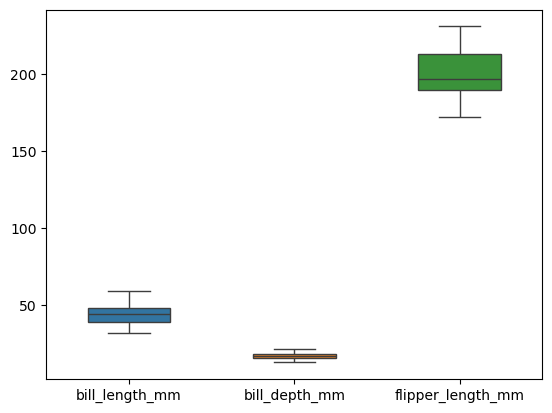

In [143]:
df1 = data[['bill_length_mm', 'bill_depth_mm','flipper_length_mm']]
sns.boxplot(data=df1, width=0.5,fliersize=5)

In [25]:
# decir algo respecto de esto...